In [ ]:
rimport os
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
import time

#visulaization modules
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
!pip install pywaffle
from pywaffle import Waffle

import xgboost as xgb
from hyperopt import fmin, tpe, hp,STATUS_OK,Trials
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix


In [ ]:
titanicDS=pd.read_csv('Titanic-Dataset.csv')

# Data at a glance

In [ ]:
titanicDS.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanicDS.shape

(891, 12)

In [ ]:
titanicDS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
titanicDS.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# data preprocessing

In [ ]:
titanicDS['Age'].min()

0.42

<Axes: ylabel='Age'>

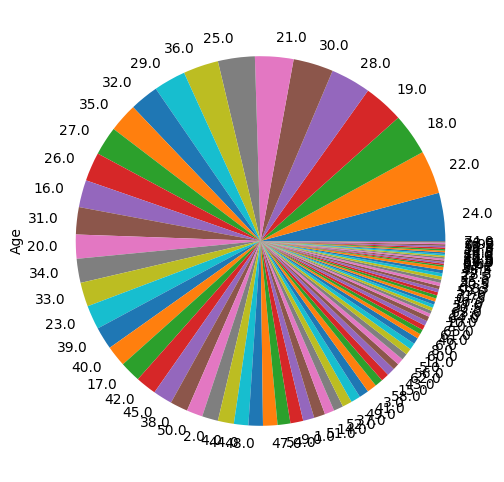

In [ ]:
titanicDS['Age'].value_counts().plot(kind='pie',figsize=(6,6))

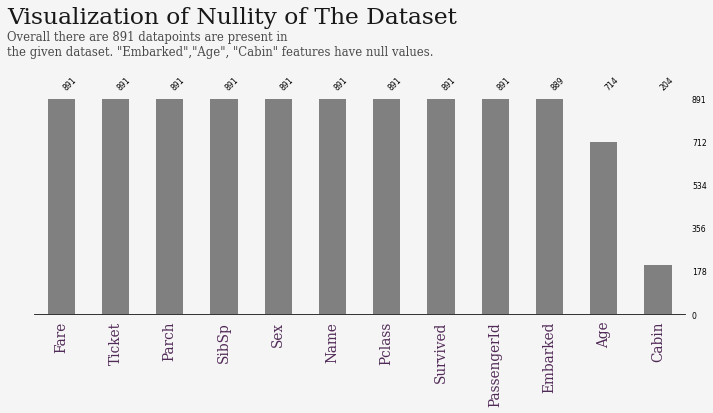

In [ ]:
color=(["grey"]*12)+["#fe346e"]
fig, ax = plt.subplots(figsize = (12,4), dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')


msno.bar(titanicDS, sort = 'descending',
         color = color,
         ax = ax, fontsize =8,
         labels = 'off',filter = 'top')

ax.text(-1,1.35,'Visualization of Nullity of The Dataset',{'font': 'Serif', 'size': 24,  'color':'black'},alpha = 0.9)
ax.text(-1,1.2,'Overall there are 891 datapoints are present in \nthe given dataset. "Embarked","Age", "Cabin" features have null values.',{'font': 'Serif', 'size': 12,  'color':'black'}, alpha = 0.7)

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,
                   ha = 'center', **{'font': 'Serif', 'size': 14,'weight':'normal','color':'#512b58'}, alpha = 1)
ax.set_yticklabels('')
ax.spines['bottom'].set_visible(True)

fig.show()

In [ ]:
# Handling missing values for Age column by filling it with the median
titanicDS["Age"] = pd.to_numeric(titanicDS["Age"], errors="coerce")  # Convert to numeric, handle non-convertible values with NaN
titanicDS["Age"] = titanicDS["Age"].fillna(titanicDS["Age"].median())

# Checking for missing values again
titanicDS.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

i'll drop uneccesary columns like PassengerId, Name,Ticket,Cabin

In [ ]:
titanicDS=titanicDS.drop(['PassengerId','Name','Ticket',"Cabin"],axis='columns')
titanicDS

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,28.0,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [ ]:
titanicDS.dropna(subset=['Embarked'], inplace=True)


In [ ]:
titanicDS.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [ ]:
titanicDS=titanicDS.replace(['S','Q','C'],[11968,9371,50100])
titanicDS=titanicDS.replace(['male','female'],[1,0])
titanicDS.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,11968
1,1,1,0,38.0,1,0,71.2833,50100
2,1,3,0,26.0,0,0,7.9250,11968
3,1,1,0,35.0,1,0,53.1000,11968
4,0,3,1,35.0,0,0,8.0500,11968
5,0,3,1,28.0,0,0,8.4583,9371
6,0,1,1,54.0,0,0,51.8625,11968
7,0,3,1,2.0,3,1,21.0750,11968
8,1,3,0,27.0,0,2,11.1333,11968
9,1,2,0,14.0,1,0,30.0708,50100


In [ ]:
titanicDS['Survived'].value_counts()

0    549
1    340
Name: Survived, dtype: int64

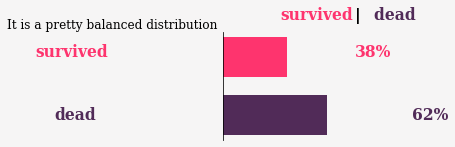

In [ ]:
x = pd.DataFrame( titanicDS.groupby(['Survived'])['Survived'].count())

# plot
fig, ax = plt.subplots(figsize = (2,2), dpi = 70)
ax.barh([1], x.Survived[1], height = 0.7, color = '#fe346e')
plt.text(-900,-0.08, 'dead',{'font': 'Serif','weight':'bold','size': '16','style':'normal', 'color':'#512b58'})
plt.text(1000,-0.08, '62%',{'font':'Serif','weight':'bold' ,'size':'16','color':'#512b58'})
ax.barh([0], x.Survived[0], height = 0.7, color = '#512b58')
plt.text(-1000,1, 'survived', {'font': 'Serif','weight':'bold','size': '16','style':'normal', 'color':'#fe346e'})
plt.text(700,1, '38%',{'font':'Serif', 'weight':'bold','size':'16','color':'#fe346e'})

fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')


plt.text(300,1.65, 'survived', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
plt.text(700,1.65, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
plt.text(800,1.65, 'dead ', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':'#512b58'})
plt.text(-1150,1.5, 'It is a pretty balanced distribution',
        {'font':'Serif', 'size':'12.5','color': 'black'})

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [ ]:
titanicDS.dropna(subset=['Age'], inplace=True)

In [ ]:
titanicDS.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,11968
1,1,1,0,38.0,1,0,71.2833,50100
2,1,3,0,26.0,0,0,7.9250,11968
3,1,1,0,35.0,1,0,53.1000,11968
4,0,3,1,35.0,0,0,8.0500,11968
5,0,3,1,28.0,0,0,8.4583,9371
6,0,1,1,54.0,0,0,51.8625,11968
7,0,3,1,2.0,3,1,21.0750,11968
8,1,3,0,27.0,0,2,11.1333,11968
9,1,2,0,14.0,1,0,30.0708,50100


<ipython-input-56-957056577e26>:8: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-56-957056577e26>:9: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




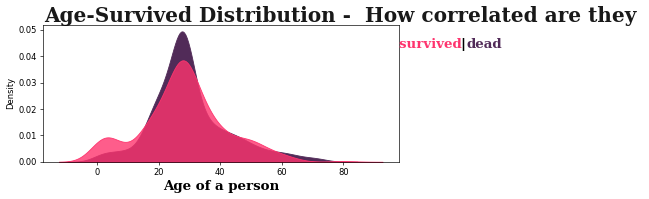

In [ ]:
fig = plt.figure(figsize = (24,10), dpi = 60)

gs = fig.add_gridspec(10,24)
gs.update(wspace = 1, hspace = 0.05)


ax3 = fig.add_subplot(gs[1:4,0:8]) #distribution plot
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 0], x = 'Age',ax = ax3, shade = True,  alpha = 1, color = '#512b58' )
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 1], x = 'Age',ax = ax3, shade = True,  alpha = 0.8, color = '#fe346e')

ax3.set_xlabel('Age of a person', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})

ax3.text(-17,0.0530,'Age-Survived Distribution -  How correlated are they ', {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}, alpha= 0.9)
ax3.text(98,0.043, 'survived ', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
ax3.text(118,0.043, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax3.text(120,0.043, 'dead', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':'#512b58'})

fig.show()

<ipython-input-57-14b054dabcc9>:8: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-57-14b054dabcc9>:9: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




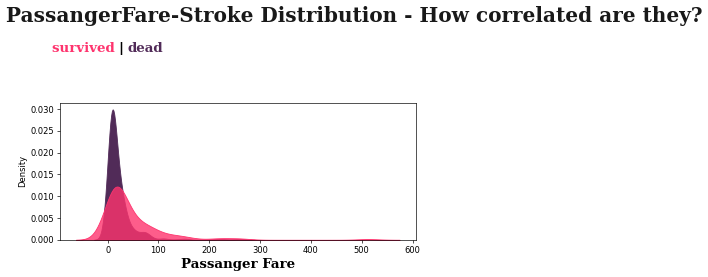

In [ ]:
fig = plt.figure(figsize = (24,10), dpi = 60)

gs = fig.add_gridspec(10,24)
gs.update(wspace = 1, hspace = 0.05)


ax3 = fig.add_subplot(gs[1:4,0:8]) #distribution plot
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 0], x = 'Fare',ax = ax3, shade = True,  alpha = 1, color = '#512b58' )
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 1], x = 'Fare',ax = ax3, shade = True,  alpha = 0.8, color = '#fe346e')

ax3.set_xlabel('Passanger Fare', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})
ax3.text(-200,0.050,'PassangerFare-Stroke Distribution - How correlated are they?', {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}, alpha= 0.9)
ax3.text(-110,0.043, 'survived ', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
ax3.text(20,0.043, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax3.text(40,0.043, 'dead', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':'#512b58'})

fig.show()

<Axes: ylabel='Sex'>

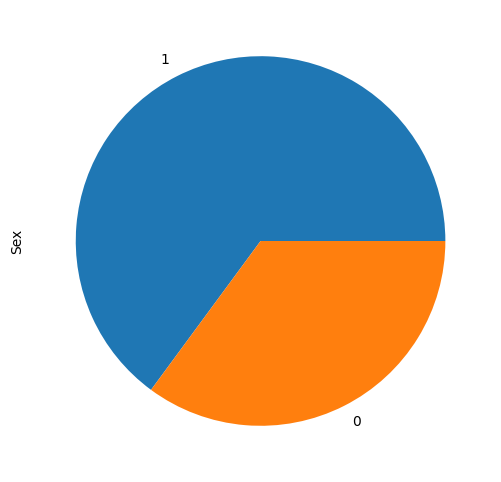

In [ ]:
titanicDS['Sex'].value_counts().plot(kind='pie',figsize=(6,6))

<ipython-input-59-fd9bfe44bf6b>:8: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-59-fd9bfe44bf6b>:9: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




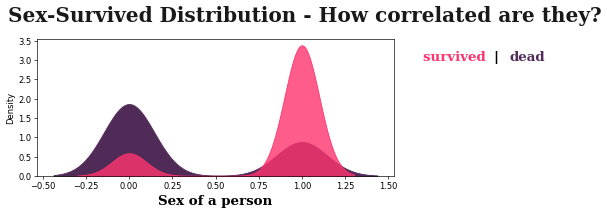

In [ ]:
fig = plt.figure(figsize = (24,10), dpi = 60)

gs = fig.add_gridspec(10,24)
gs.update(wspace = 1, hspace = 0.05)


ax3 = fig.add_subplot(gs[1:4,0:8]) #distribution plot
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 1], x = 'Sex',ax = ax3, shade = True,  alpha = 1, color = '#512b58' )
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 0], x = 'Sex',ax = ax3, shade = True,  alpha = 0.8, color = '#fe346e')

ax3.set_xlabel('Sex of a person', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})

ax3.text(-0.7,4,'Sex-Survived Distribution - How correlated are they?', {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}, alpha= 0.9)
ax3.text(1.7,3, 'survived ', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
ax3.text(2.11,3, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax3.text(2.2,3, 'dead', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':'#512b58'})

fig.show()

<ipython-input-60-5d853ca33a2f>:8: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-60-5d853ca33a2f>:9: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




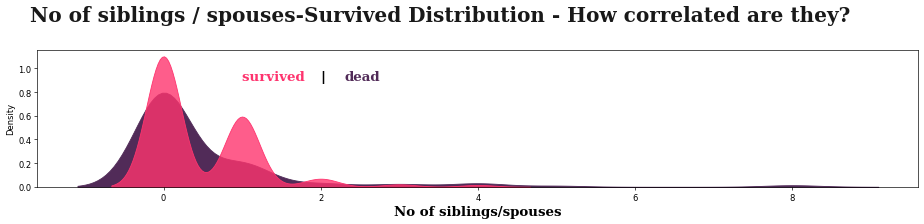

In [ ]:
fig = plt.figure(figsize = (24,10), dpi = 60)

gs = fig.add_gridspec(10,10)
gs.update(wspace = 1, hspace = 0.05)


ax3 = fig.add_subplot(gs[1:4,0:8]) #distribution plot
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 0], x = 'SibSp',ax = ax3, shade = True,  alpha = 1, color = '#512b58' )
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 1], x = 'SibSp',ax = ax3, shade = True,  alpha = 0.8, color = '#fe346e')

ax3.set_xlabel('No of siblings/spouses', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})
ax3.text(-1.7,1.40,'No of siblings / spouses-Survived Distribution - How correlated are they?', {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}, alpha= 0.9)
ax3.text(1,0.9, 'survived ', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
ax3.text(2,0.9, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax3.text(2.3,0.9, 'dead', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':'#512b58'})

fig.show()

<ipython-input-61-d8caf22dd127>:8: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-61-d8caf22dd127>:9: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




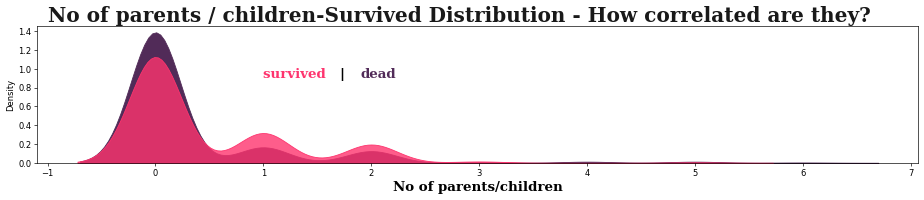

In [ ]:
fig = plt.figure(figsize = (24,10), dpi = 60)

gs = fig.add_gridspec(10,10)
gs.update(wspace = 1, hspace = 0.05)


ax3 = fig.add_subplot(gs[1:4,0:8]) #distribution plot
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 0], x = 'Parch',ax = ax3, shade = True,  alpha = 1, color = '#512b58' )
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 1], x = 'Parch',ax = ax3, shade = True,  alpha = 0.8, color = '#fe346e')

ax3.set_xlabel('No of parents/children', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})
ax3.text(-1,1.50,'No of parents / children-Survived Distribution - How correlated are they?', {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}, alpha= 0.9)
ax3.text(1,0.9, 'survived ', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
ax3.text(1.7,0.9, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax3.text(1.9,0.9, 'dead', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':'#512b58'})

fig.show()

<ipython-input-62-385f259e1514>:8: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-62-385f259e1514>:9: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




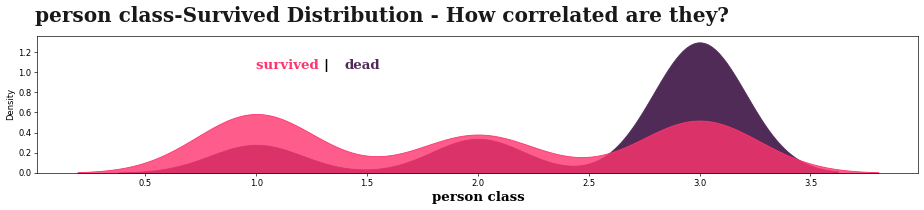

In [ ]:
fig = plt.figure(figsize = (24,10), dpi = 60)

gs = fig.add_gridspec(10,10)
gs.update(wspace = 1, hspace = 0.05)


ax3 = fig.add_subplot(gs[1:4,0:8]) #distribution plot
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 0], x = 'Pclass',ax = ax3, shade = True,  alpha = 1, color = '#512b58' )
sns.kdeplot(data = titanicDS[titanicDS['Survived'] == 1], x = 'Pclass',ax = ax3, shade = True,  alpha = 0.8, color = '#fe346e')

ax3.set_xlabel('person class', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})
ax3.text(0,1.5,'person class-Survived Distribution - How correlated are they?', {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}, alpha= 0.9)
ax3.text(1,1.03, 'survived ', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
ax3.text(1.3,1.03, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax3.text(1.4,1.03, 'dead', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':'#512b58'})

fig.show()

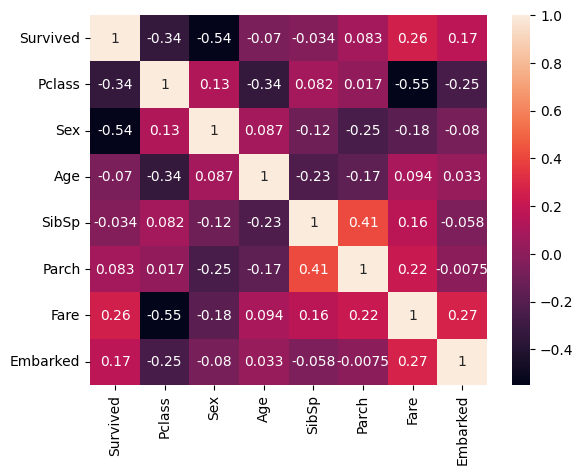

In [ ]:
ax = sns.heatmap(titanicDS.corr(), annot=True)

In [ ]:
x=titanicDS.drop((['Survived']), axis='columns')
y=titanicDS['Survived']
print(x)
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size=0.2 ,random_state=42)

     Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         3    1  22.0      1      0   7.2500     11968
1         1    0  38.0      1      0  71.2833     50100
2         3    0  26.0      0      0   7.9250     11968
3         1    0  35.0      1      0  53.1000     11968
4         3    1  35.0      0      0   8.0500     11968
..      ...  ...   ...    ...    ...      ...       ...
886       2    1  27.0      0      0  13.0000     11968
887       1    0  19.0      0      0  30.0000     11968
888       3    0  28.0      1      2  23.4500     11968
889       1    1  26.0      0      0  30.0000     50100
890       3    1  32.0      0      0   7.7500      9371

[889 rows x 7 columns]


In [ ]:
learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = []
train_XG = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(x_train, y_train)
    train_XG.append(xgb_classifier.score(x_train, y_train))
    test_XG.append(xgb_classifier.score(x_test, y_test))

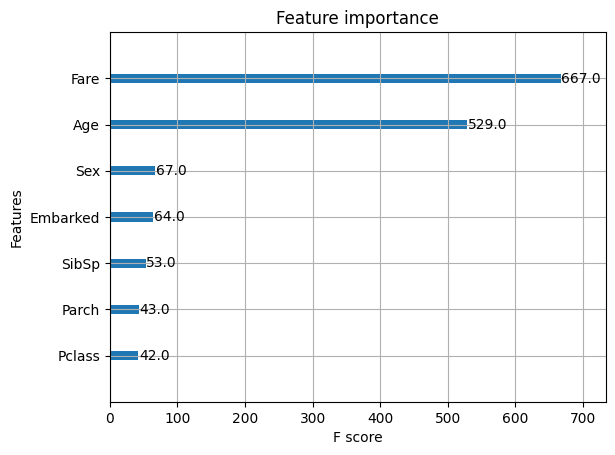

<Figure size 1600x1200 with 0 Axes>

In [ ]:
xgb.plot_importance(xgb_classifier)
plt.figure(figsize = (16, 12))
plt.show()

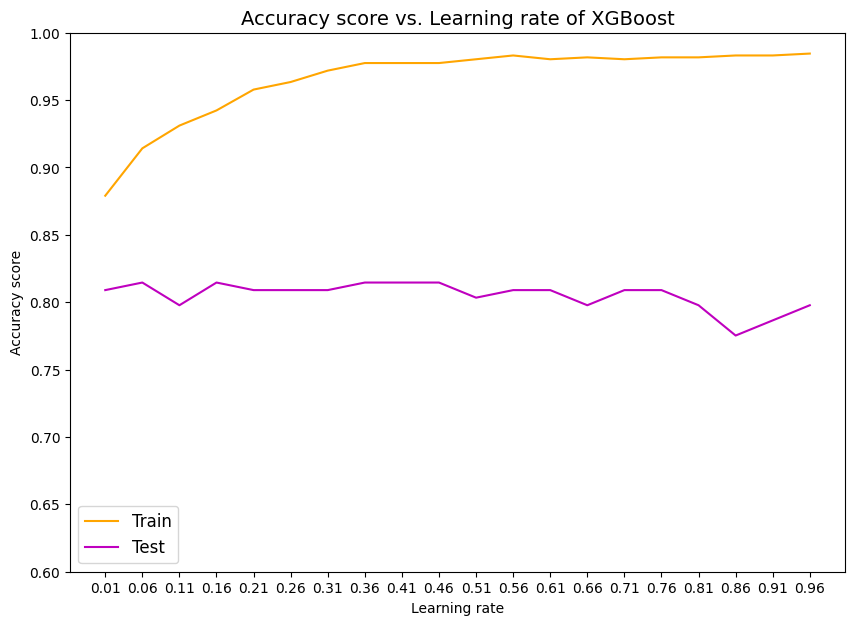

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

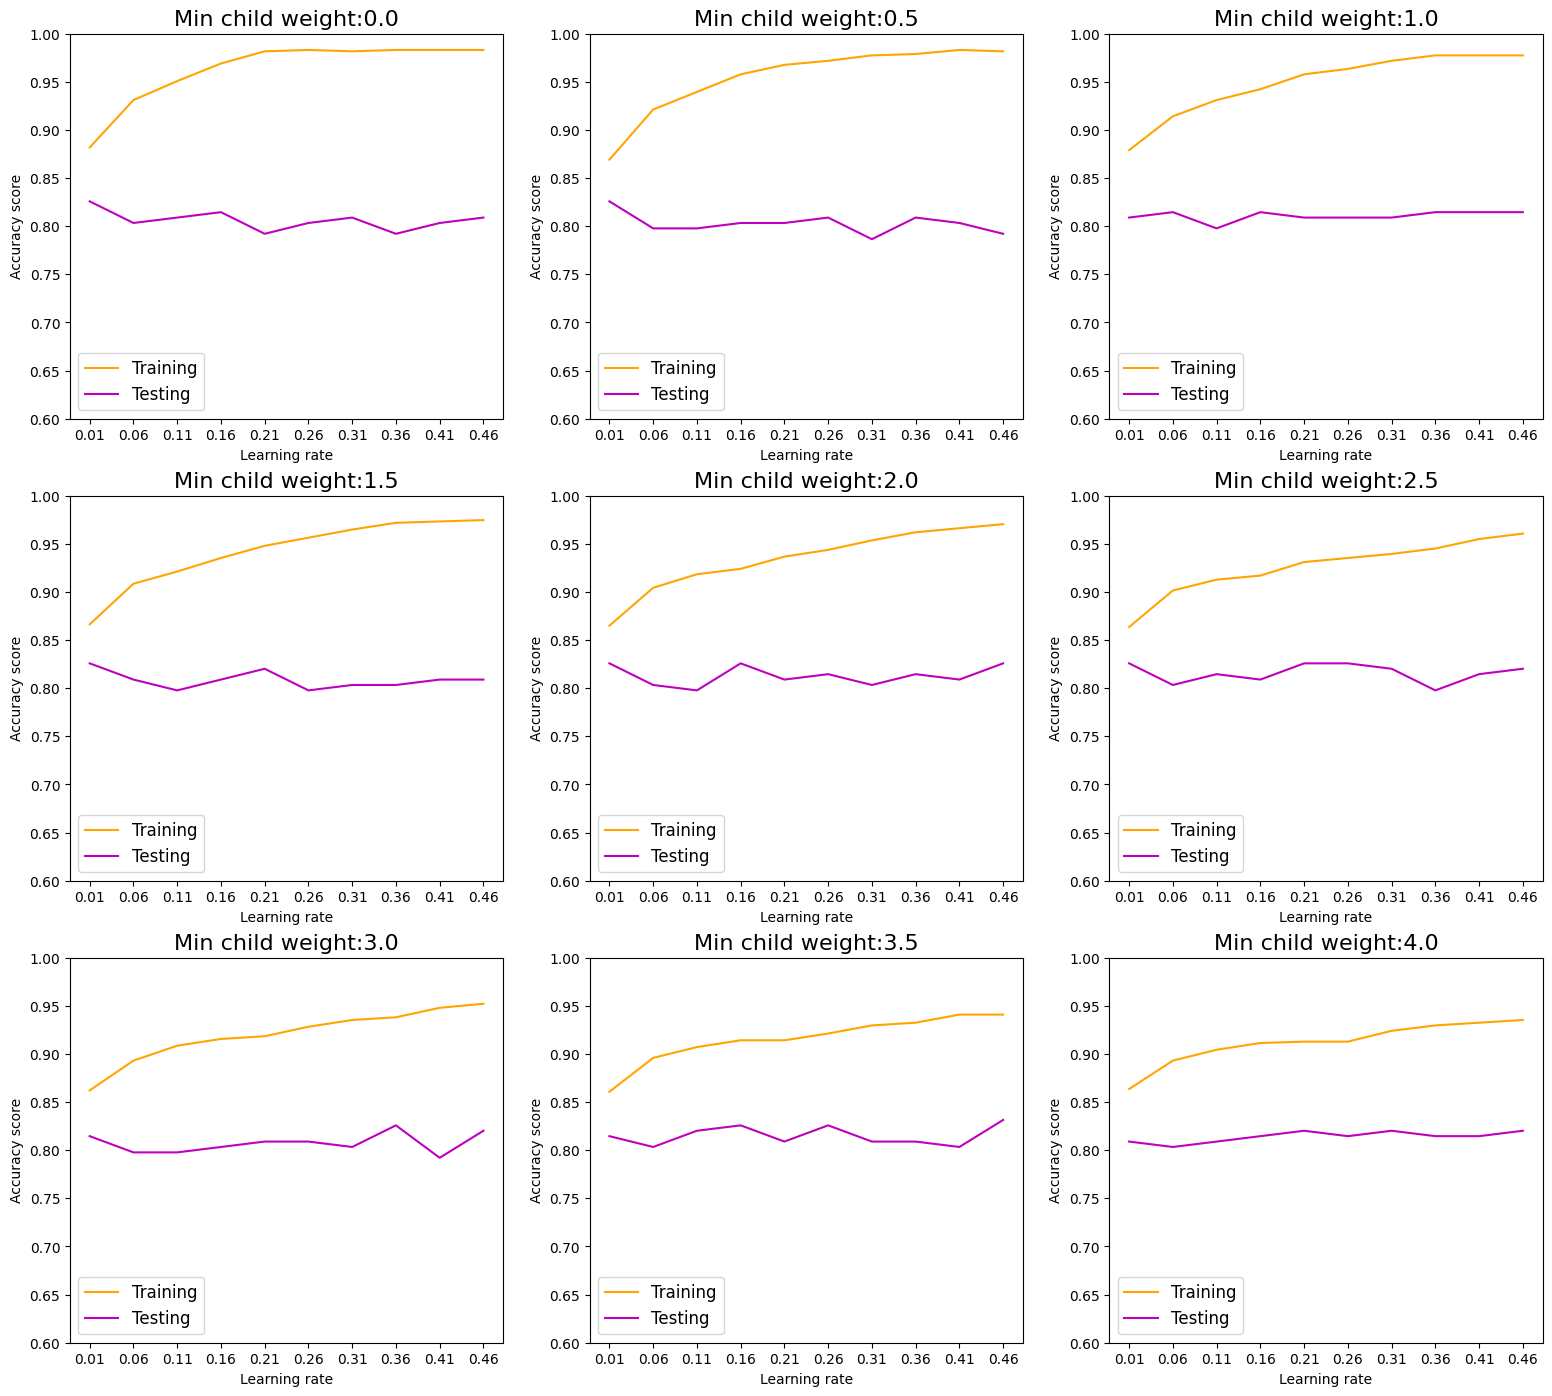

In [ ]:
# new learning rate range
learning_rate_range = np.arange(0.01, 0.5, 0.05)
fig = plt.figure(figsize=(19, 17))
idx = 1
# grid search for min_child_weight
for weight in np.arange(0, 4.5, 0.5):
    train = []
    test = []
    for lr in learning_rate_range:
        xgb_classifier = xgb.XGBClassifier(eta = lr, reg_lambda=1, min_child_weight=weight)
        xgb_classifier.fit(x_train, y_train)
        train.append(xgb_classifier.score(x_train, y_train))
        test.append(xgb_classifier.score(x_test, y_test))
    fig.add_subplot(3, 3, idx)
    idx += 1
    plt.plot(learning_rate_range, train, c='orange', label='Training')
    plt.plot(learning_rate_range, test, c='m', label='Testing')
    plt.xlabel('Learning rate')
    plt.xticks(learning_rate_range)
    plt.ylabel('Accuracy score')
    plt.ylim(0.6, 1)
    plt.legend(prop={'size': 12}, loc=3)
    title = "Min child weight:" + str(weight)
    plt.title(title, size=16)
plt.show()

In [ ]:
# Define the hyperparameter space
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    evaluation = [( x_train, y_train), ( x_test, y_test)]

    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)


    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
  2%|▏         | 2/100 [00:00<00:06, 14.56trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
  6%|▌         | 6/100 [00:00<00:06, 14.48trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
  8%|▊         | 8/100 [00:00<00:06, 14.87trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 12%|█▏        | 12/100 [00:00<00:05, 14.82trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 16%|█▌        | 16/100 [00:01<00:06, 13.11trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 20%|██        | 20/100 [00:01<00:05, 13.87trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 22%|██▏       | 22/100 [00:01<00:05, 13.76trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 26%|██▌       | 26/100 [00:01<00:05, 13.34trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 28%|██▊       | 28/100 [00:02<00:05, 13.32trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 32%|███▏      | 32/100 [00:02<00:05, 12.67trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
 34%|███▍      | 34/100 [00:02<00:05, 12.43trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 36%|███▌      | 36/100 [00:02<00:05, 11.90trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 40%|████      | 40/100 [00:03<00:05, 11.73trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 42%|████▏     | 42/100 [00:03<00:04, 11.63trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
 45%|████▌     | 45/100 [00:03<00:06,  7.91trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 48%|████▊     | 48/100 [00:04<00:05,  9.71trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 50%|█████     | 50/100 [00:04<00:04, 10.06trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 62%|██████▏   | 62/100 [00:05<00:03, 10.52trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
SCORE:
 64%|██████▍   | 64/100 [00:05<00:03,  9.59trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.6123595505617978
SCORE:
0.6123595505617978
 66%|██████▌   | 66/100 [00:05<00:03,  8.51trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 68%|██████▊   | 68/100 [00:06<00:04,  7.46trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 70%|███████   | 70/100 [00:06<00:04,  6.73trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 72%|███████▏  | 72/100 [00:06<00:04,  6.07trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
 73%|███████▎  | 73/100 [00:06<00:04,  5.79trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
 74%|███████▍  | 74/100 [00:07<00:04,  5.68trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
 75%|███████▌  | 75/100 [00:07<00:05,  4.83trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
 76%|███████▌  | 76/100 [00:07<00:06,  3.88trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 78%|███████▊  | 78/100 [00:08<00:06,  3.42trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 80%|████████  | 80/100 [00:08<00:04,  4.69trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 82%|████████▏ | 82/100 [00:09<00:03,  5.14trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 84%|████████▍ | 84/100 [00:09<00:02,  5.85trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 88%|████████▊ | 88/100 [00:09<00:01,  8.25trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 91%|█████████ | 91/100 [00:10<00:00,  9.35trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 93%|█████████▎| 93/100 [00:10<00:00,  9.91trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
 96%|█████████▌| 96/100 [00:10<00:00,  9.73trial/s, best loss: -0.6123595505617978]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:8

SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
SCORE:
0.6123595505617978
100%|██████████| 100/100 [00:10<00:00,  9.11trial/s, best loss: -0.6123595505617978]


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7201649338282665, 'gamma': 1.6720412251488481, 'max_depth': 3.0, 'min_child_weight': 1.0, 'reg_alpha': 124.0, 'reg_lambda': 0.4817543624578223}


In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(max_depth=10 ,criterion='gini',min_samples_split=4,min_samples_leaf=4,max_features=None,random_state=42)

decision_tree_model.fit(x_train, y_train)

y_train_pred_dt = decision_tree_model.predict(x_train)

accuracy_train_dt = accuracy_score(y_train, y_train_pred_dt)

print("Accuracy on Training Set: {:.2f}".format(accuracy_train_dt* 100))

y_test_pred= decision_tree_model.predict(x_test)

Score = decision_tree_model.score(x_test, y_test)

print("Accuracy By Decision Tree Model:",Score*100)

Accuracy on Training Set: 88.05
Accuracy By Decision Tree Model: 80.33707865168539


Text(0.5, 1.0, 'Confusion Matrix For decision tree')

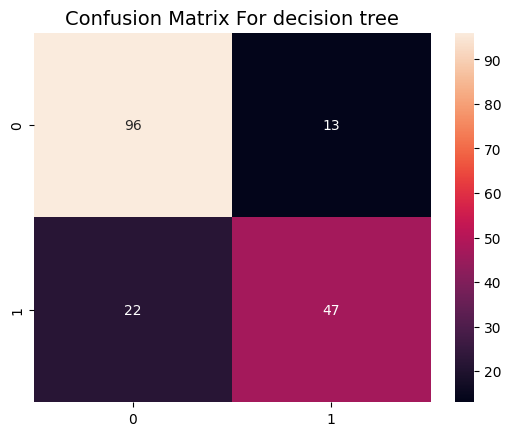

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True)
plt.title("Confusion Matrix For decision tree", fontsize=14)